# **Required Installations**

In [21]:
!pip install keras-cv tensorflow --upgrade --quiet
!pip install keras==3.0.0 --upgrade --quiet

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.5.0 requires tensorflow~=2.13.0, but you have tensorflow 2.15.0.post1 which is incompatible.
tensorflow-text 2.13.0 requires tensorflow<2.14,>=2.13.0; platform_machine != "arm64" or platform_system != "Darwin", but you have tensorflow 2.15.0.post1 which is incompatible.
tensorflowjs 4.14.0 requires packaging~=23.1, but you have packaging 21.3 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0.post1 requires keras<2.16,>=2.15.0, but you have keras 3.0.0 which is incompatible.
tensorflow-decision-forests 1.5.0 requires tensorflow~=2.13.0, but you have tensorflow 2.15.0.post1 which is incompatible.
tensorflow-text 2.13.0 requ

# **Setup**

In [22]:
# Required Imports
import os

# Set the `KERAS_BACKEND` to `tensorflow`
os.environ["KERAS_BACKEND"] = "tensorflow"

# Import numpy, matplotlib, seaborn, and other necessary libraries
import json
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import keras and its modules
import keras
from keras import ops
from keras import layers
from keras.applications import VGG19
from keras import optimizers
from keras.optimizers import schedules
from keras import losses
from keras import metrics

import keras_cv

# Import tensorflow for [`tf.data`](https://www.tensorflow.org/api_docs/python/tf/data) and its preprocessing functions
import tensorflow as tf
import tensorflow_datasets as tfds

tfds.disable_progress_bar()

# Set the seeds for reproducibility
SEEDS = 42
np.random.seed(SEEDS)
tf.random.set_seed(SEEDS)

# **Version Checking**

In [23]:
# Print the versions of Keras, TensorFlow, and Keras-CV
print(tf.__version__)
print(keras_cv.__version__)
print(keras.__version__)

2.15.0
0.8.0.dev0
3.0.0


# **Define Hyperparameters**

In [24]:
# Set the batch size, image size, and number of epochs
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)
EPOCHS = 20

# **Gather Malaria Dataset**

In [25]:
# Set the dataset name
dataset_name = "malaria"

# Load the dataset and split it into train and test sets
(train_ds, test_ds), ds_info = tfds.load(
    dataset_name, split=["train[:80%]", "train[80%:]"], with_info=True, as_supervised=True
)

# Get the number of classes in the dataset
NUM_CLASSES = ds_info.features["label"].num_classes

def package_inputs(image, label):
    """
    Packages the input image and label into a dictionary.

    Args:
        image: The input image.
        label: The corresponding label.

    Returns:
        A dictionary containing the input image and label.
    """
    return {"images": image, "labels": tf.one_hot(label, NUM_CLASSES)}

# Map the `package_inputs` function to the train and test sets
train_ds = train_ds.map(package_inputs, num_parallel_calls=tf.data.AUTOTUNE)
eval_ds = test_ds.map(package_inputs, num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle the training dataset
train_ds = train_ds.shuffle(BATCH_SIZE * 16)

# **Visualise the dataset**

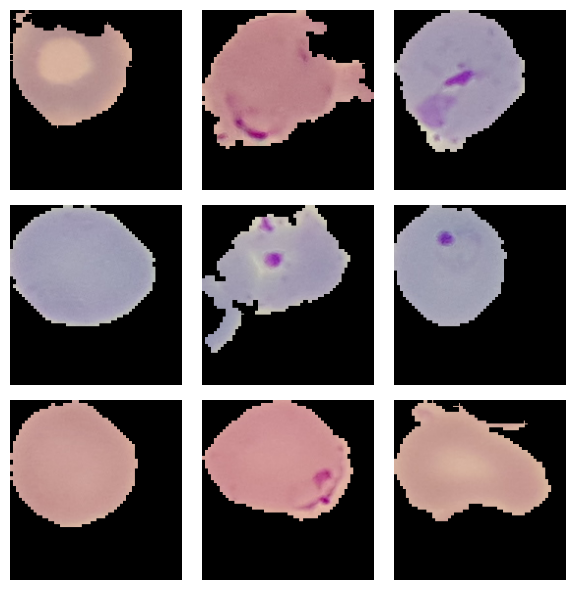

In [26]:
# Applying raggad batching to the train and test sets
train_ds = train_ds.ragged_batch(BATCH_SIZE)
eval_ds = eval_ds.ragged_batch(BATCH_SIZE)

# Image batch for visualization from the train set
batch = next(iter(train_ds.take(1)))
image_batch = batch["images"]

# Visualize the images in the batch
keras_cv.visualization.plot_image_gallery(
    image_batch.to_tensor(),
    rows=3,
    cols=3,
    value_range=(0, 255),
    show=True,
)

# **Data Augmentation**

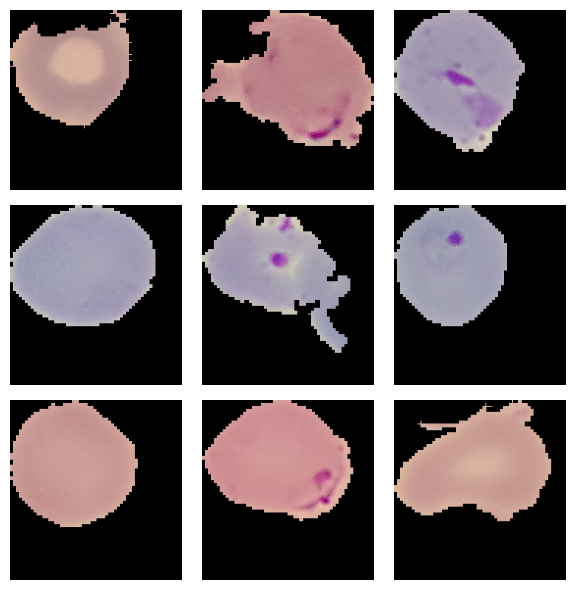

In [27]:
# Randomly flip the images in the batch
random_flip = keras_cv.layers.RandomFlip()
augmenters = [random_flip]

# Apply the augmenters to the image batch
image_batch = random_flip(image_batch)

# Visualize the images in the batch
keras_cv.visualization.plot_image_gallery(
    image_batch.to_tensor(),
    rows=3,
    cols=3,
    value_range=(0, 255),
    show=True,
)

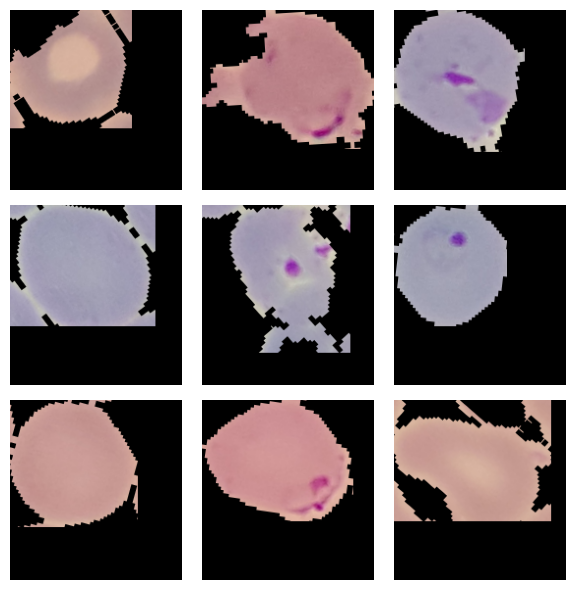

In [28]:
# Randomly rotate the images in the batch
random_rotation = keras_cv.layers.RandomRotation(factor=0.15)
augmenters = [random_rotation]

# Apply the augmenters to the image batch
image_batch = random_rotation(image_batch)

# Visualize the images in the batch
keras_cv.visualization.plot_image_gallery(
    image_batch.to_tensor(),
    rows=3,
    cols=3,
    value_range=(0, 255),
    show=True,
)

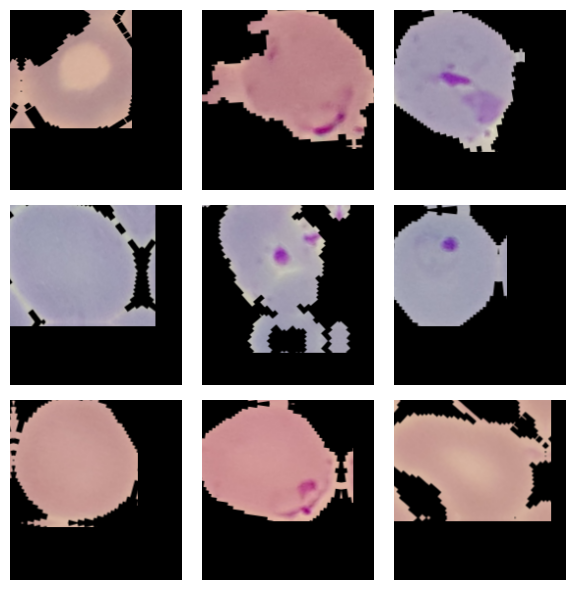

In [29]:
# Randomly translate the images in the batch
random_translation = keras_cv.layers.RandomTranslation(height_factor=0.1, width_factor=0.1)
augmenters = [random_translation]

# Apply the augmenters to the image batch
image_batch = random_translation(image_batch)

# Visualize the images in the batch
keras_cv.visualization.plot_image_gallery(
    image_batch.to_tensor(),
    rows=3,
    cols=3,
    value_range=(0, 255),
    show=True,
)

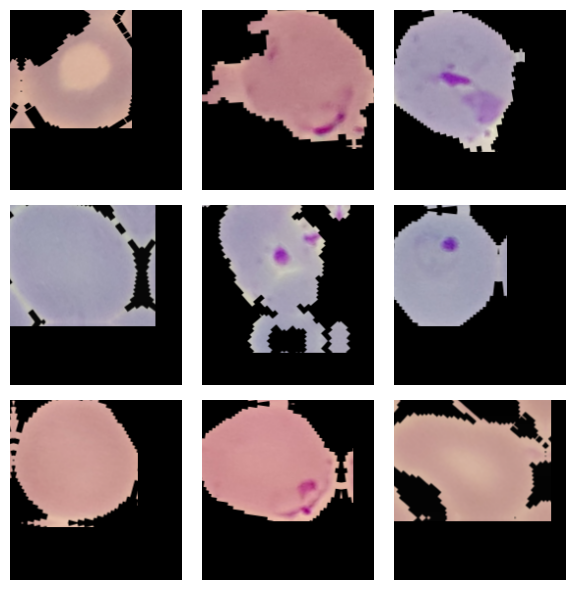

In [30]:
# Randomly change contrast of the images in the batch
random_contrast = keras_cv.layers.RandomContrast(factor=0.1, value_range=(0, 255))
augmenters = [random_contrast]

# Apply the augmenters to the image batch
image_batch = random_contrast(image_batch)

# Visualize the images in the batch
keras_cv.visualization.plot_image_gallery(
    image_batch.to_tensor(),
    rows=3,
    cols=3,
    value_range=(0, 255),
    show=True,
)

In [31]:
def create_augmenter_fn(augmenters):
    """
    Creates an augmenter function that applies a list of augmenters to the inputs.

    Args:
        augmenters (list): List of augmenter functions to be applied.

    Returns:
        augmenter_fn (function): Augmenter function that applies the augmenters to the inputs.
    """
    def augmenter_fn(inputs):
        """
        Apply a series of augmentations to the input data.

        Args:
            inputs: The input data to be augmented.

        Returns:
            The augmented data.
        """
        for augmenter in augmenters:
            inputs = augmenter(inputs)
        return inputs

    return augmenter_fn

# Apply all the previously defined augmenters to the train set
augmenter_fn = create_augmenter_fn(augmenters)
train_ds = train_ds.map(augmenter_fn, num_parallel_calls=tf.data.AUTOTUNE)

# **Prepare Inputs**

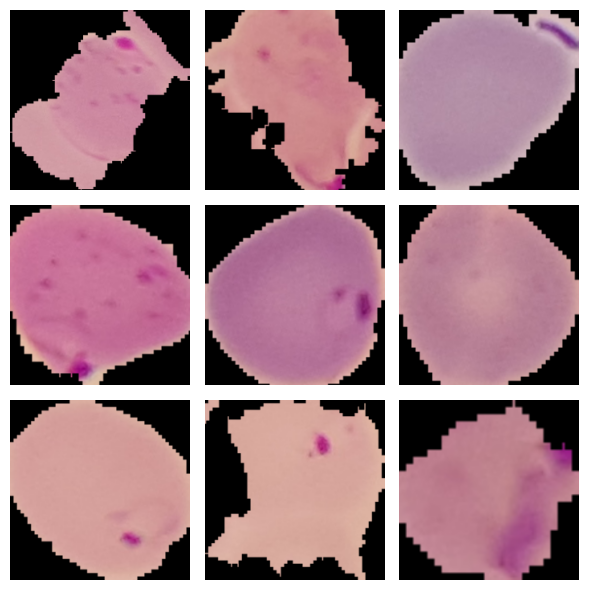

In [32]:
# Resizing the images in the train and test sets
inference_resizing = keras_cv.layers.Resizing(
    IMAGE_SIZE[0], IMAGE_SIZE[1], crop_to_aspect_ratio=True
)
train_ds = train_ds.map(inference_resizing, num_parallel_calls=tf.data.AUTOTUNE)
eval_ds = eval_ds.map(inference_resizing, num_parallel_calls=tf.data.AUTOTUNE)

# Visualize the images in the batch
image_batch = next(iter(eval_ds.take(1)))["images"]
keras_cv.visualization.plot_image_gallery(
    image_batch,
    rows=3,
    cols=3,
    value_range=(0, 255),
    show=True,
)

In [33]:
def unpackage_dict(inputs):
    """
    Unpackages a dictionary and returns the values of the 'images' and 'labels' keys.

    Parameters:
    inputs (dict): A dictionary containing the 'images' and 'labels' keys.

    Returns:
    tuple: A tuple containing the values of the 'images' and 'labels' keys.
    """
    return inputs["images"], inputs["labels"]

# Unpackage the dictionaries in the train and test sets
train_ds = train_ds.map(unpackage_dict, num_parallel_calls=tf.data.AUTOTUNE)
eval_ds = eval_ds.map(unpackage_dict, num_parallel_calls=tf.data.AUTOTUNE)

# **Optimizer Tuning**

In [34]:
def lr_warmup_cosine_decay(
    global_step,
    warmup_steps,
    hold=0,
    total_steps=0,
    start_lr=0.0,
    target_lr=1e-2,
):
    """
    Computes the learning rate using warmup and cosine decay.

    Args:
        global_step (int): The current global step.
        warmup_steps (int): The number of warmup steps.
        hold (int, optional): The number of steps to hold the learning rate after warmup. Defaults to 0.
        total_steps (int, optional): The total number of steps. Defaults to 0.
        start_lr (float, optional): The initial learning rate. Defaults to 0.0.
        target_lr (float, optional): The target learning rate. Defaults to 1e-2.

    Returns:
        float: The computed learning rate.
    """
    # Cosine decay
    learning_rate = (
        0.5
        * target_lr
        * (
            1
            + ops.cos(
                math.pi
                * ops.convert_to_tensor(
                    global_step - warmup_steps - hold, dtype="float32"
                )
                / ops.convert_to_tensor(
                    total_steps - warmup_steps - hold, dtype="float32"
                )
            )
        )
    )

    warmup_lr = target_lr * (global_step / warmup_steps)
    
    if hold > 0:
        learning_rate = ops.where(
            global_step > warmup_steps + hold, learning_rate, target_lr
        )
    
    learning_rate = ops.where(global_step < warmup_steps, warmup_lr, learning_rate)
    return learning_rate


class WarmUpCosineDecay(schedules.LearningRateSchedule):
    """
    Learning rate schedule that combines warm-up, cosine decay, and hold phases.

    Args:
        warmup_steps (int): Number of steps for the warm-up phase.
        total_steps (int): Total number of steps for the learning rate schedule.
        hold (int): Number of steps to hold the learning rate after the warm-up phase.
        start_lr (float, optional): Initial learning rate. Defaults to 0.0.
        target_lr (float, optional): Target learning rate. Defaults to 1e-2.
    """

    def __init__(self, warmup_steps, total_steps, hold, start_lr=0.0, target_lr=1e-2):
        super().__init__()
        self.start_lr = start_lr
        self.target_lr = target_lr
        self.warmup_steps = warmup_steps
        self.total_steps = total_steps
        self.hold = hold

    def __call__(self, step):
        lr = lr_warmup_cosine_decay(
            global_step=step,
            total_steps=self.total_steps,
            warmup_steps=self.warmup_steps,
            start_lr=self.start_lr,
            target_lr=self.target_lr,
            hold=self.hold,
        )

        return ops.where(step > self.total_steps, 0.0, lr)

# **Define Optimizer and Loss**

In [35]:
# Total number of images, warmup steps, and hold steps for the learning rate schedule
total_images = 27558
total_steps = (total_images // BATCH_SIZE) * EPOCHS
warmup_steps = int(0.1 * total_steps)
hold_steps = int(0.45 * total_steps)

# Learning rate schedule
schedule = WarmUpCosineDecay(
    start_lr=0.05,
    target_lr=1e-2,
    warmup_steps=warmup_steps,
    total_steps=total_steps,
    hold=hold_steps,
)

# Optimizer
optimizer_fn = optimizers.SGD(
    weight_decay=5e-4,
    learning_rate=schedule,
    momentum=0.9,
)

# Loss function
loss_fn = losses.BinaryCrossentropy(label_smoothing=0.1)

# **Set up Callbacks**

In [36]:
# Callbacks for the training process
train_callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=2, restore_best_weights=True
    )
]

# **Transfer Learning from Pre-trained Weights**

In [37]:
def build_model(num_classes):
    """
    Build a model for malaria diagnosis using EfficientNet.

    Args:
        num_classes (int): The number of classes for classification.

    Returns:
        keras.Model: The compiled model.

    """
    # Create the base model from the pre-trained model EfficientNet
    inputs = layers.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
    model = VGG19(include_top=False, input_tensor=inputs, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top of pretrained model
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(num_classes, activation="sigmoid", name="pred")(x)

    # Compile the model
    model = keras.Model(inputs, outputs, name="VGG19")
    optimizer = optimizer_fn
    model.compile(
        optimizer=optimizer, loss=loss_fn, metrics=["accuracy"]
    )
    return model

In [38]:
# Model summary
model = build_model(NUM_CLASSES)
model.summary()

Model: "VGG19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)       │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)      │      1,792 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)      │     36,928 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)      │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)     │     73,856 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)     │    147,584 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)       │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)       │    295,168 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)       │    590,080 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)       │    590,080 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block3_conv4 (Conv2D)           │ (None, 56, 56, 256)       │    590,080 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)       │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)       │  1,180,160 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)       │  2,359,808 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)       │  2,359,808 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block4_conv4 (Conv2D)           │ (None, 28, 28, 512)       │  2,359,808 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)       │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)       │  2,359,808 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)       │  2,359,808 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)       │  2,359,808 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block5_conv4 (Conv2D)           │ (None, 14, 14, 512)       │  2,359,808 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ avg_pool                        │ (None, 512)               │          0 │
│ (GlobalAveragePooling2D)        │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ batch_normalization_1           │ (None, 512)               │      2,048 │
│ (BatchNormalization)            │                           │          

 Total params: 20,027,458 (76.40 MB)

 Trainable params: 2,050 (8.01 KB)

 Non-trainable params: 20,025,408 (76.39 MB)

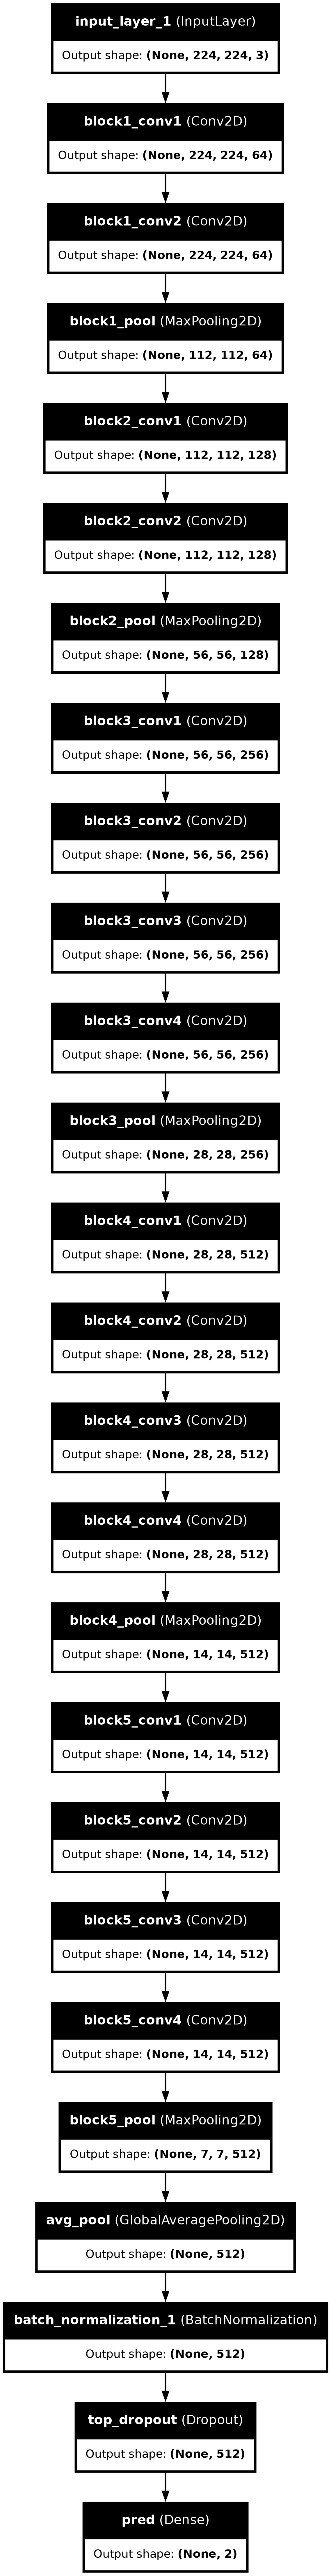

In [39]:
# Model plot
keras.utils.plot_model(model, to_file='vgg19_model_plot.png', show_shapes=True, show_layer_names=True)

# **Train the Model**

In [40]:
# Model training
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=eval_ds,
    callbacks=train_callbacks
)

Epoch 1/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 5016s 7s/step - accuracy: 0.7312 - loss: 0.6243 - val_accuracy: 0.9336 - val_loss: 0.3357
Epoch 2/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 5063s 7s/step - accuracy: 0.9299 - loss: 0.3502 - val_accuracy: 0.9381 - val_loss: 0.3224
Epoch 3/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 4999s 7s/step - accuracy: 0.9294 - loss: 0.3391 - val_accuracy: 0.9360 - val_loss: 0.3291
Epoch 4/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 4972s 7s/step - accuracy: 0.9339 - loss: 0.3363 - val_accuracy: 0.9407 - val_loss: 0.3189
Epoch 5/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 5032s 7s/step - accuracy: 0.9305 - loss: 0.3401 - val_accuracy: 0.9416 - val_loss: 0.3191
Epoch 6/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 4994s 7s/step - accuracy: 0.9305 - loss: 0.3409 - val_accuracy: 0.9403 - val_loss: 0.3216


# **Plot the Training and Validation Metrics**

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


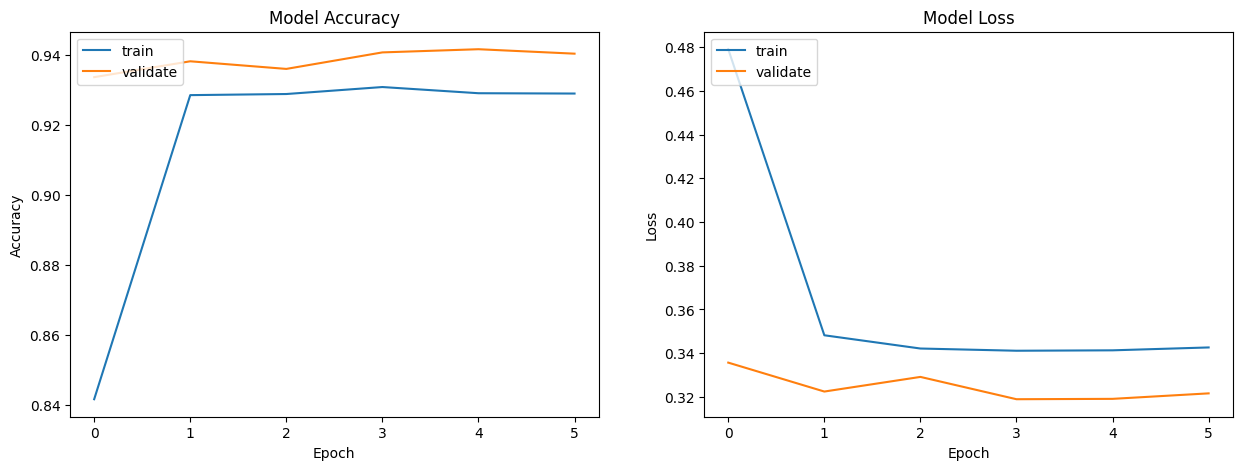

In [43]:
def plotmodelhistory(history):
    """
    Plots the model accuracy and loss for the training and validation sets.

    Parameters:
    history (keras.callbacks.History): The history object returned by the model.fit() function.

    Returns:
    None
    """

    # Plotting the model accuracy and loss for the training and validation sets
    fig, axs = plt.subplots(1,2,figsize=(15,5)) 
    
    # summarize history for accuracy
    axs[0].plot(history.history['accuracy']) 
    axs[0].plot(history.history['val_accuracy']) 
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy') 
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['train', 'validate'], loc='upper left')

    # summarize history for loss
    axs[1].plot(history.history['loss']) 
    axs[1].plot(history.history['val_loss']) 
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss') 
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['train', 'validate'], loc='upper left')
    plt.show()

# list all data in history
print(history.history.keys())

plotmodelhistory(history)

# **Evaluate the Model**

In [44]:
# Evaluate the model on the test set
accuracy = model.evaluate(eval_ds)[1] * 100
print("Accuracy: {:.2f}%".format(accuracy))

173/173 ━━━━━━━━━━━━━━━━━━━━ 982s 6s/step - accuracy: 0.9443 - loss: 0.3150
Accuracy: 94.07%


# **Conclusion**

- Model accuracy of VGG19 in the training set is 93.05% and in the validation set is 94.07%.